purpose: generate network colocalization values for Locomotor-Externalizing network and compare NPS scores

# set-up

In [1]:
import os
import pandas as pd
import ndex2
import networkx as nx
from netcoloc import netprop_zscore
from netcoloc import netprop
from netcoloc import network_colocalization
import sys
import random
#os.chdir('/tscc/projects/ps-palmer/brittany/rare_common_alcohol/rare_common_alcohol_comparison/notebooks/')
#from rca_functions import *
os.chdir('/tscc/projects/ps-palmer/brittany/SUD_cross_species/scripts')
from network_functions import *
from network_validation_functions import *
from plotting_functions import *
os.chdir('/tscc/projects/ps-palmer/brittany/SUD_cross_species/')

In [2]:
random_seed=random.seed(211)

In [3]:
save_fig=True

In [4]:
#whether to rerun the significance analysis for network colocalization
rerun_colocalization=False

In [5]:
#create a file called environ_ndex_meta.py where you save variables 'ndex_user' and 'ndex_password'
#otherwise will prompt you to define those within the notebooks
if os.path.isfile('../environ_ndex_meta.py'):
    print ('NDEx credentials imported from meta file')
    sys.path.insert(1, '../')
    from environ_ndex_meta import *
    sys.path.pop(1)
else:
    # Prompt the user for a username
    ndex_user = input("Enter your NDEx username: ")
    # Prompt the user for a password
    ndex_password = input("Enter your NDEx password: ")

NDEx credentials imported from meta file


# functions

In [12]:
plt.rcParams.update({'font.size': 16})

# Interactome Set-up

pcnet2- versions 
from wright et al. 2024 preprint:
PCNet 2.0= best-performing ranked composite (top 15 interactomes, 3.85M interactions)
PCNet 2.1= top 8 interactomes, 1.75M interactions
PCNet 2.2= top 10 co-citation-free interactomes, 3.32M interactions 

In [7]:
UUIDs

{'PCNet2.0': 'd73d6357-e87b-11ee-9621-005056ae23aa',
 'PCNet2.1': 'e9c574f4-e87a-11ee-9621-005056ae23aa',
 'PCNet2.2': '8b4b54fa-e87d-11ee-9621-005056ae23aa',
 'signor_rat': '76be57cd-afe8-11e9-8bb4-0ac135e8bacf',
 'signor_human': '523fff27-afe8-11e9-8bb4-0ac135e8bacf',
 'signor_mouse': '656370fa-afe8-11e9-8bb4-0ac135e8bacf'}

In [8]:
interactome_name='PCNet2.0'

In [9]:
interactome=import_interactome(UUIDs=UUIDs,interactome_name=interactome_name)
all_nodes=list(interactome.nodes())

PCNet2.0
Name: PCNet 2.0
Nodes: 19267
Edges: 3852119
Node Attributes: 19267
Edge Attributes: 19260595

number of nodes:
19267

number of edges:
3852119


In [10]:
# pre calculate the matricies used for network propagation
print('\ncalculating w_prime')
w_prime = netprop.get_normalized_adjacency_matrix(interactome, conserve_heat=True)

print('\ncalculating w_double_prime')
w_double_prime = netprop.get_individual_heats_matrix(w_prime, .5)


calculating w_prime

calculating w_double_prime


In [11]:
colour_dict

{'ext': '#785EF0',
 'ext_alt': '#648FFF',
 'ext_munged': '#785EF0',
 'ext_munged_alt': '#648FFF',
 'loco': '#FFB000',
 'loco_alt': '#FE6100',
 'loco_gsem': '#FFB000',
 'loco_gsem_alt': '#FE6100',
 'shared': '#DC267F',
 'other': '#CCCCCC',
 'shared_alt': '#780534',
 'addict-rf': '#A8E5A0',
 'addict-rf_alt': '#63AC00',
 'shared_addict-rf': '#31739C',
 'shared_alt_addict-rf': '#56B4E9'}

# import NPS scores and seed genes

In [13]:
seed_dict=import_seed_dict(mag_dir,file_dict,bonf_dict,gene_col_dict,all_nodes)
seed_dict.keys()

dict_keys(['loco_bonf', 'loco_top500', 'loco_FDR', 'loco_gsem_bonf', 'loco_gsem_top500', 'loco_gsem_FDR', 'ext_bonf', 'ext_top500', 'ext_FDR', 'ext_st22', 'loco_mega_fus_naac_bonf', 'loco_mega_fus_naac_top500', 'loco_mega_fus_naac_FDR', 'ext_fus_naac_bonf', 'ext_fus_naac_top500', 'ext_fus_naac_FDR'])

In [14]:
#dictionary of human control traits
ctrl_dict={}
ctrl_traits=['facial_hair', 'age_smkinit', 'antisoc', 'friend_sat', 'hr', 'infant_bw', 'LDL', 'maternal_smok', 'townsend', 'age_menarche', 'neurot','addict-rf']
for t in ctrl_traits:
    ctrl_dict[t]=pd.read_csv('gwas_ctrl_hm/magma/seed_genes/'+t+'_annot.tsv',sep='\t')
for t in ctrl_traits:
    seed_dict[t+'_FDR']=(set(ctrl_dict[t][ctrl_dict[t]['Q']<0.05]['GENE']))
    seed_dict[t+'_bonf']=(set(ctrl_dict[t][ctrl_dict[t]['P']<0.05/len(ctrl_dict[t])]['GENE']))
    seed_dict[t+'_top500']=set(ctrl_dict[t][(ctrl_dict[t]['GENE'].isin(all_nodes))].nsmallest(500,'P')['GENE'])

In [15]:
seed_dict.keys()

dict_keys(['loco_bonf', 'loco_top500', 'loco_FDR', 'loco_gsem_bonf', 'loco_gsem_top500', 'loco_gsem_FDR', 'ext_bonf', 'ext_top500', 'ext_FDR', 'ext_st22', 'loco_mega_fus_naac_bonf', 'loco_mega_fus_naac_top500', 'loco_mega_fus_naac_FDR', 'ext_fus_naac_bonf', 'ext_fus_naac_top500', 'ext_fus_naac_FDR', 'facial_hair_FDR', 'facial_hair_bonf', 'facial_hair_top500', 'age_smkinit_FDR', 'age_smkinit_bonf', 'age_smkinit_top500', 'antisoc_FDR', 'antisoc_bonf', 'antisoc_top500', 'friend_sat_FDR', 'friend_sat_bonf', 'friend_sat_top500', 'hr_FDR', 'hr_bonf', 'hr_top500', 'infant_bw_FDR', 'infant_bw_bonf', 'infant_bw_top500', 'LDL_FDR', 'LDL_bonf', 'LDL_top500', 'maternal_smok_FDR', 'maternal_smok_bonf', 'maternal_smok_top500', 'townsend_FDR', 'townsend_bonf', 'townsend_top500', 'age_menarche_FDR', 'age_menarche_bonf', 'age_menarche_top500', 'neurot_FDR', 'neurot_bonf', 'neurot_top500', 'addict-rf_FDR', 'addict-rf_bonf', 'addict-rf_top500'])

In [16]:
NPS_dict,NPS_dict_series=import_NPS_scores(seed_dict,UUIDs)
NPS_dict.keys()

dict_keys(['loco_bonf_PCNet2.0', 'loco_bonf_PCNet2.1', 'loco_bonf_PCNet2.2', 'loco_FDR_PCNet2.0', 'loco_FDR_PCNet2.1', 'loco_FDR_PCNet2.2', 'loco_gsem_bonf_PCNet2.0', 'loco_gsem_bonf_PCNet2.1', 'loco_gsem_bonf_PCNet2.2', 'loco_gsem_FDR_PCNet2.0', 'loco_gsem_FDR_PCNet2.1', 'loco_gsem_FDR_PCNet2.2', 'ext_bonf_PCNet2.0', 'ext_bonf_PCNet2.1', 'ext_bonf_PCNet2.2', 'ext_top500_PCNet2.0', 'ext_top500_PCNet2.1', 'ext_top500_PCNet2.2', 'ext_FDR_PCNet2.0', 'ext_FDR_PCNet2.1', 'ext_FDR_PCNet2.2', 'ext_st22_PCNet2.0', 'ext_st22_PCNet2.1', 'ext_st22_PCNet2.2', 'loco_mega_fus_naac_bonf_PCNet2.0', 'loco_mega_fus_naac_bonf_PCNet2.1', 'loco_mega_fus_naac_bonf_PCNet2.2', 'loco_mega_fus_naac_FDR_PCNet2.0', 'loco_mega_fus_naac_FDR_PCNet2.1', 'loco_mega_fus_naac_FDR_PCNet2.2', 'ext_fus_naac_bonf_PCNet2.0', 'ext_fus_naac_bonf_PCNet2.1', 'ext_fus_naac_bonf_PCNet2.2', 'ext_fus_naac_top500_PCNet2.0', 'ext_fus_naac_top500_PCNet2.1', 'ext_fus_naac_top500_PCNet2.2', 'ext_fus_naac_FDR_PCNet2.0', 'ext_fus_naac_FDR_

# choose datasets for analysis

In [17]:
#modify for correct genesets
cut_r= 'FDR'
cut_h='top500'
trait_r='loco_gsem'
trait_h='ext'

label_h,label_r,seed_h,seed_r,NPS_h,NPS_r,NPS=return_analysis_datasets(trait_r,cut_r,trait_h,cut_h,seed_dict,NPS_dict,interactome_name)

# compare seed genes

In [18]:
seed_r.intersection(seed_h)

{'ARF5',
 'CHRNA2',
 'CPNE4',
 'FSCN3',
 'GCC1',
 'MDH1',
 'PAX4',
 'POU3F2',
 'PSMC3',
 'PTK2B',
 'RNF150',
 'SLC39A13',
 'UGP2',
 'VPS54',
 'ZNF800'}

In [19]:
save_fig=False

{'ARF5', 'GCC1', 'PSMC3', 'SLC39A13', 'FSCN3', 'MDH1', 'POU3F2', 'PAX4', 'RNF150', 'CPNE4', 'ZNF800', 'CHRNA2', 'PTK2B', 'VPS54', 'UGP2'}


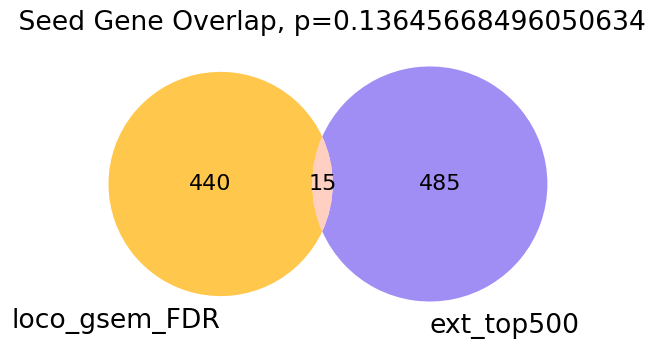

In [25]:
venn_seeds(seed_r, seed_h, label_r, label_h, colour_dict[trait_r],colour_dict[trait_h],all_nodes,interactome_name, savefig=save_fig)

# compare stats

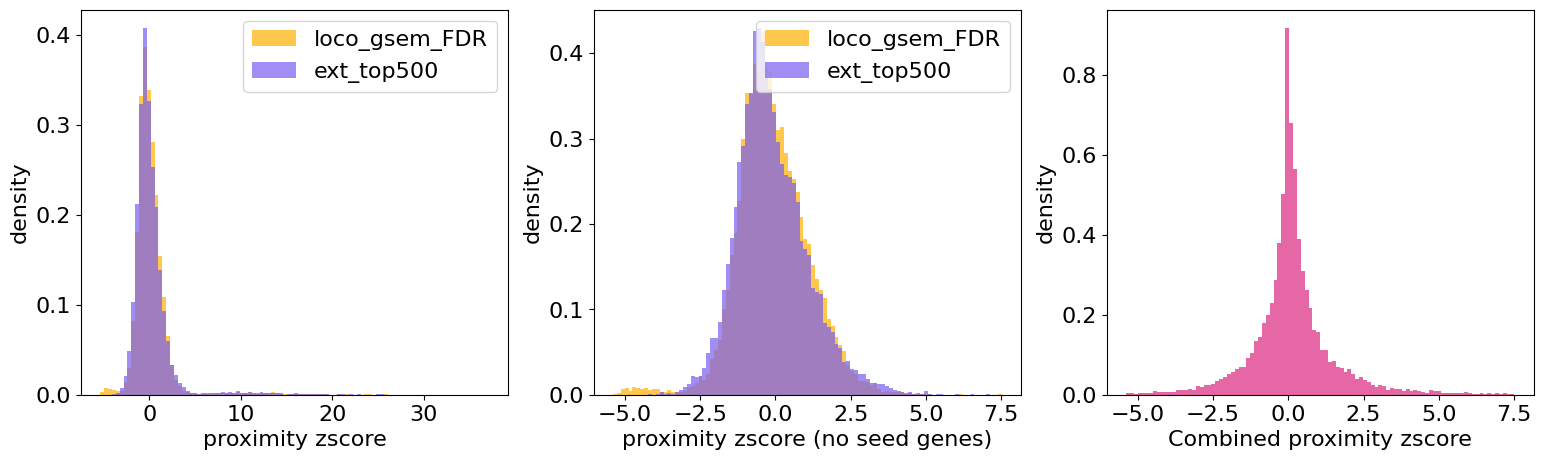

In [24]:
#import rare seed gene list and NPS scores
plt_histogram(tblr=NPS_r, tblc=NPS_h, 
              tblr_label=label_r, tblc_label=label_h,
              tblr_seed=seed_dict[label_r], tblc_seed=seed_dict[label_h], 
              colour_r=colour_dict[trait_r],colour_c=colour_dict[trait_h],colour_shared=colour_dict['shared'],
              tblr_lim=cut_single,
              tblc_lim=cut_single,
              comb_lim=cut_comb,
              savefig=save_fig,
             filename='NPS_hist'+'_'+label_r+'_'+label_h+'_'+interactome_name)


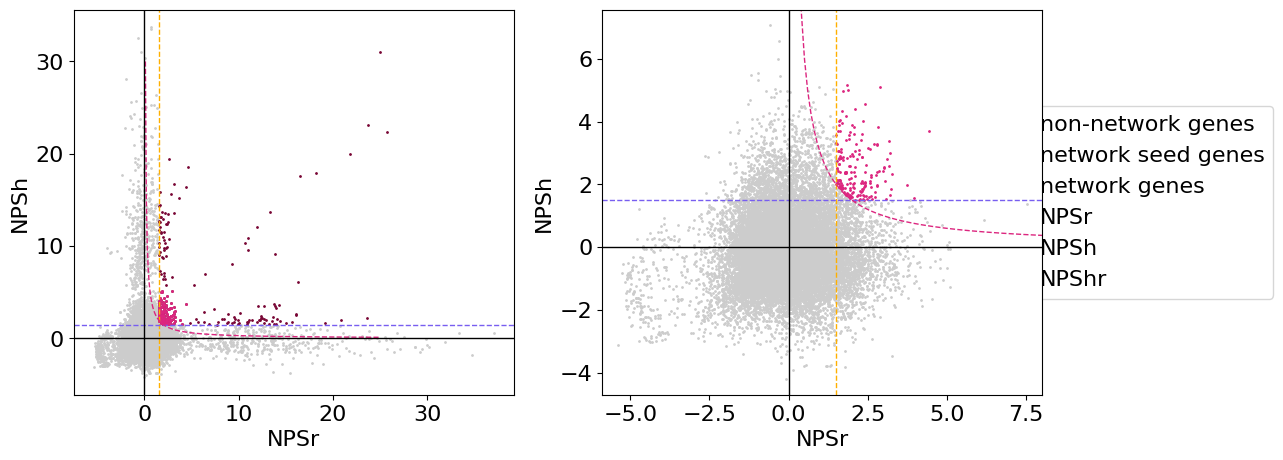

In [29]:
#import rare seed gene list and NPS scores
plt_scatter_NPS(tblr=NPS_r, tblc=NPS_h, 
              tblr_label='NPSr', tblc_label='NPSh',
              tblr_seed=seed_dict[label_r], tblc_seed=seed_dict[label_h], 
              colour_r=colour_dict[trait_r],colour_c=colour_dict[trait_h],colour_shared=colour_dict['shared'],colour_nonseed=colour_dict['shared_alt'],
              tblr_lim=cut_single,
              tblc_lim=cut_single,
              comb_lim=cut_comb,
              savefig=save_fig,
             filename='NPS_scatter'+'_'+label_r+'_'+label_h+'_'+interactome_name)


In [124]:
zlist=[cut_comb]
z12list=[cut_single]

In [125]:
#set the Z-score cutoffs to calculate network enrichment significance
zlist = [1,2,3,4,5,6,7,8,9,10]
z12list = [1,1.5,2,3,4,5]


In [26]:
coloc_filename=f'colocalization_scores/colocScore_{label_r}_{label_h}_{interactome_name}.tsv'
if rerun_colocalization | (not (os.path.exists(coloc_filename))):
    print('analyzing colocalization')
    netcoloc_enrichment_df = network_colocalization.calculate_network_enrichment(NPS_r,NPS_h,
                                                                             zthresh_list = zlist,
                                                                             z12thresh_list=z12list,
                                                                             verbose=False)
    #netcoloc_enrichment_df=netcoloc_enrichment_df[netcoloc_enrichment_df['z_comb']>=netcoloc_enrichment_df['NPS_single']]
    print(netcoloc_enrichment_df)
    netcoloc_enrichment_df['rat_dataset']=label_r
    netcoloc_enrichment_df['human_dataset']=label_h
    if save_fig:
        netcoloc_enrichment_df.to_csv(coloc_filename,sep='\t',index=False)
else:
    print(f'reading in {coloc_filename}')
    netcoloc_enrichment_df=pd.read_csv(coloc_filename,sep='\t')
pOverlap=float(netcoloc_enrichment_df[(netcoloc_enrichment_df['z_comb']==cut_comb) & (netcoloc_enrichment_df['z_12']==cut_single)]['empirical_p'])

reading in colocalization_scores/colocScore_loco_gsem_FDR_addict-rf_FDR_PCNet2.0.tsv


1.5
311


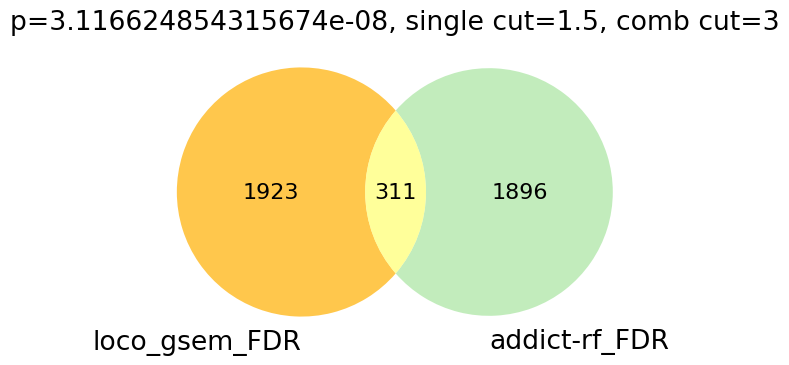

In [27]:
venn_net(tblr=NPS_r,tblc=NPS_h, tblr_label=label_r,tblc_label= label_h,p_net_overlap=pOverlap,
         colour_r=colour_dict[trait_r],colour_c=colour_dict[trait_h],colour_shared=colour_dict['shared'],
         tblr_lim=cut_single, tblc_lim=cut_single, comb_lim=3, savefig=save_fig)

In [37]:
tbl_z=combine_nps_table(NPS_r, NPS_h)

In [47]:
t=tbl_z[(tbl_z.NPSc>cut_single)&(tbl_z.NPSr>cut_single)&(tbl_z.NPScr>cut_comb)]

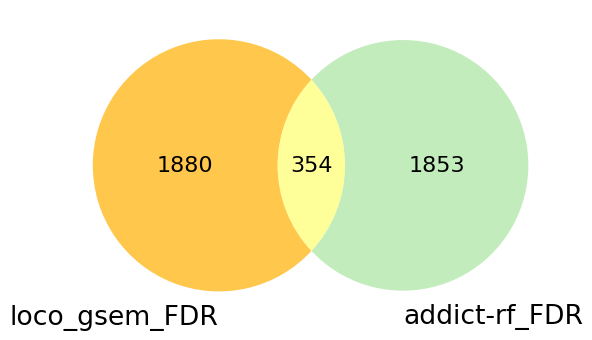

In [45]:
tbl_z=combine_nps_table(NPS_r, NPS_h)
Nr=len(tbl_z[(tbl_z.NPSr>cut_single)])
Nh=len(tbl_z[(tbl_z.NPSc>cut_single)])
Nrh=len(tbl_z[(tbl_z.NPSc>cut_single)&(tbl_z.NPSr>cut_single)])
Nnet=len(tbl_z[(tbl_z.NPSc>cut_single)&(tbl_z.NPSr>cut_single)&(tbl_z.NPScr>cut_comb)])

venn2((Nr-Nrh,Nh-Nrh,Nrh), 
      set_labels=(label_r, label_h),
  set_colors=(colour_r=colour_dict[trait_r],colour_c=colour_dict[trait_h]), alpha = 0.7)

plt.savefig('figures/network_venn_for_figure'+label_r+'_'+label_h+'.svg',bbox_inches='tight')


## histogram observed vs permuted network size

In [28]:
observed_sz, permuted_sz = network_colocalization.calculate_expected_overlap(NPS_r.iloc[:,0], NPS_h.iloc[:,0], 
                                                            z_score_threshold=cut_comb, z1_threshold=cut_single,
                                                            z2_threshold=cut_single, num_reps=10000, plot=False)                                                                   

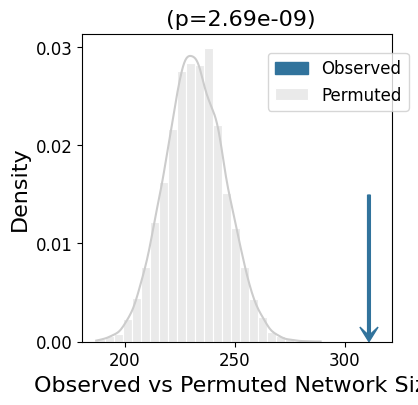

In [30]:
plot_permutation_histogram(permuted_sz, observed_sz, title="", xlabel="Observed vs Permuted Network Size", color=colour_dict['other'], arrow_color=colour_dict['shared'],
                           savefig=save_fig, filename='networksize_hist'+'_'+label_r+'_'+label_h+'_'+interactome_name)

In [32]:
colour_dict['shared2']

'#31739C'

## histogram observed vs permuted mean NPS

Overlap seed genes: 85


100%|██████████| 1000/1000 [00:03<00:00, 255.54it/s]
/tscc/nfs/home/bsleger/miniconda3/envs/env-std-py38/lib/python3.8/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/tscc/nfs/home/bsleger/miniconda3/envs/env-std-py38/lib/python3.8/site-packages/matplotlib/patches.py:1470: RuntimeWarning: invalid value encountered in double_scalars
  sx = self._dy / distance
/tscc/nfs/home/bsleger/miniconda3/envs/env-std-py38/lib/python3.8/site-packages/matplotlib/patches.py:1477: RuntimeWarning: invalid value encountered in double_scalars
  self._y + self._dy,


Cannot round result, p= nan


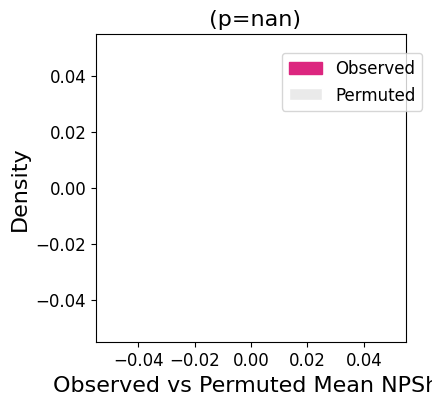

In [107]:
# Generate a null distribution of mean NPS by shuffling the z_scores. Note, due to randomization this distribution will not be exactly the same as the reported result
observed_net, permuted_net = calculate_mean_z_score_distribution(NPS_r.iloc[:,0], NPS_h.iloc[:,0], num_reps=1000,
                                                        zero_double_negatives=False, overlap_control="bin",
                                                        seed1=list(set(seed_r).intersection(all_nodes)), seed2=list(set(seed_h).intersection(all_nodes)))
plot_permutation_histogram(permuted_net, observed_net, title="", xlabel="Observed vs Permuted Mean NPShr", color=colour_dict['other'], arrow_color=colour_dict['shared'],savefig=False, 
                           filename='mean_NPScr_hist'+'_'+label_r+'_'+label_h+'_'+interactome_name)

Overlap seed genes: 85


100%|██████████| 1000/1000 [00:03<00:00, 255.45it/s]
/tscc/nfs/home/bsleger/miniconda3/envs/env-std-py38/lib/python3.8/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/tscc/nfs/home/bsleger/miniconda3/envs/env-std-py38/lib/python3.8/site-packages/matplotlib/patches.py:1470: RuntimeWarning: invalid value encountered in double_scalars
  sx = self._dy / distance
/tscc/nfs/home/bsleger/miniconda3/envs/env-std-py38/lib/python3.8/site-packages/matplotlib/patches.py:1477: RuntimeWarning: invalid value encountered in double_scalars
  self._y + self._dy,


Cannot round result, p= nan


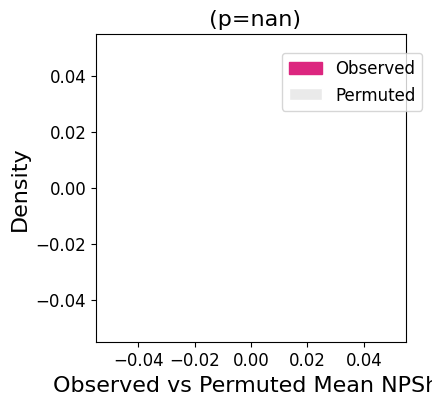

In [108]:
# Generate a null distribution of mean NPS by shuffling the z_scores. Note, due to randomization this distribution will not be exactly the same as the reported result
observed_net, permuted_net = calculate_mean_z_score_distribution(NPS_r.iloc[:,0], NPS_h.iloc[:,0], num_reps=1000,
                                                        zero_double_negatives=False, overlap_control="remove",
                                                        seed1=list(set(seed_r).intersection(all_nodes)), seed2=list(set(seed_h).intersection(all_nodes)))
plot_permutation_histogram(permuted_net, observed_net, title="", xlabel="Observed vs Permuted Mean NPShr", color=colour_dict['other'], arrow_color=colour_dict['shared'],savefig=False, 
                           filename='mean_NPScr_hist'+'_'+label_r+'_'+label_h+'_'+interactome_name+'remove')

# sensitivity analysis -NPS scores

In [81]:
if ('netcoloc_enrichment_df' not in vars()):
    netcoloc_enrichment_df=pd.read_csv('colocalization_scores/colocScore_'+label_r+'_'+label_h+'_'+interactome_name+'.tsv',sep='\t')

In [82]:
netcoloc_enrichment_df.head()

,z_comb,z_12,observed_overlap,expected_overlap_mean,expected_overlap_std,empirical_p,obs_exp,rat_dataset,human_dataset
0,1,1.0,873,686.12,18.666162,6.770322e-24,1.272372,loco_gsem_FDR,addict-rf_FDR
1,1,1.5,354,257.92,13.873486,2.173103e-12,1.372519,loco_gsem_FDR,addict-rf_FDR
2,1,2.0,129,88.11,9.177031,4.181202e-06,1.464079,loco_gsem_FDR,addict-rf_FDR
3,1,3.0,33,19.35,4.309002,7.680208e-04,1.705426,loco_gsem_FDR,addict-rf_FDR
4,1,4.0,25,10.95,2.987892,1.286163e-06,2.283105,loco_gsem_FDR,addict-rf_FDR


In [83]:
netcoloc_enrichment_df['logp']=-np.log10(netcoloc_enrichment_df['empirical_p'])
netcoloc_enrichment_df.columns=['NPS_common-rare', 'NPS_single', 'observed_overlap', 'expected_overlap_mean',
       'expected_overlap_std', 'empirical_p', 'obs_exp', 'rare_dataset',
       'common_dataset', 'logp']

In [84]:
temp=netcoloc_enrichment_df[netcoloc_enrichment_df['empirical_p']<0.05/len(netcoloc_enrichment_df)]

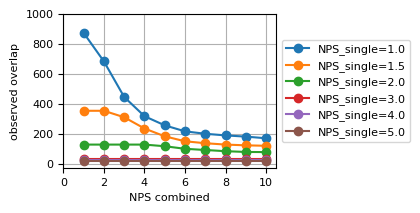

In [85]:
NPS_lineplot(netcoloc_enrichment_df,'observed_overlap','network_overlap_'+label_r+'_'+label_h+'_'+interactome_name+'.svg',xrange=[0,10.5],yrange=[-25,1000],savefig=save_fig)

/tscc/projects/ps-palmer/brittany/rare_common_alcohol/rare_common_alcohol_comparison/notebooks/rca_functions.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['-log10(p)']=-np.log10(df['empirical_p'])


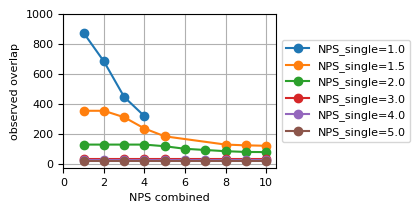

In [86]:
NPS_lineplot(temp,'observed_overlap','network_overlap_sig_'+label_r+'_'+label_h+'_'+interactome_name+'.svg',xrange=[0,10.5], yrange=[-25,1000],savefig=save_fig)

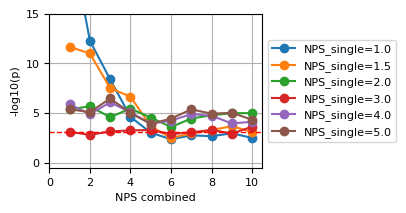

In [87]:
NPS_lineplot(netcoloc_enrichment_df,'-log10(p)','network_overlap_pval_'+label_r+'_'+label_h+'_'+interactome_name+'.svg',xrange=[0,10.5],yrange=[-0.5,15], savefig=save_fig,sigline=True)

/tscc/projects/ps-palmer/brittany/rare_common_alcohol/rare_common_alcohol_comparison/notebooks/rca_functions.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['-log10(p)']=-np.log10(df['empirical_p'])


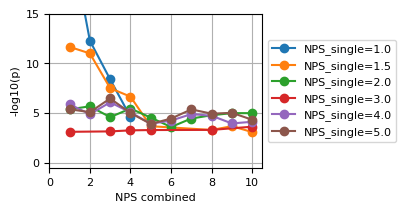

In [88]:
NPS_lineplot(temp,'-log10(p)','network_overlap_pval_sig_'+label_r+'_'+label_h+'_'+interactome_name+'.svg',xrange=[0,10.5], yrange=[-0.5,15],savefig=save_fig)

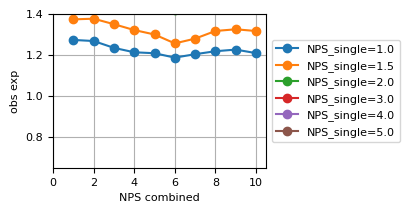

In [89]:
NPS_lineplot(netcoloc_enrichment_df,'obs_exp','network_overlap_obsexp_'+label_r+'_'+label_h+'_'+interactome_name+'.svg',xrange=[0,10.5],yrange=[.65,1.4],savefig=save_fig)

/tscc/projects/ps-palmer/brittany/rare_common_alcohol/rare_common_alcohol_comparison/notebooks/rca_functions.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['-log10(p)']=-np.log10(df['empirical_p'])


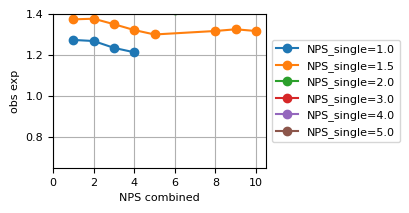

In [90]:
NPS_lineplot(temp,'obs_exp','network_overlap_obsexp_sig_'+label_r+'_'+label_h+'_'+interactome_name+'.svg',xrange=[0,10.5],yrange=[.65,1.4],savefig=save_fig)

# generate colocalized locomotor-ext network (unannotated)- save to ndexbio

In [91]:
pd.Series(NPS_h['z'])

0
TGFBR1            0.342351
TGFBR2            2.227588
SMAD3             1.773098
TGFB1            -0.704968
SMAD2            -0.699098
                    ...   
TRBV5-1          -0.204637
TRBV19           -0.111692
TRAV12-3         -0.111522
TRAV22            0.111310
ARMCX5-GPRASP2   -0.257224
Name: z, Length: 19267, dtype: float64

In [133]:
net=network_colocalization.calculate_network_overlap_subgraph(
    interactome, pd.Series(NPS_r['z']), pd.Series(NPS_h['z']), cut_comb, cut_single, cut_single)
net2=format_network(net, label_r, label_h, seed_r , seed_h, NPS_r['z'], NPS_h['z'])
print(net2.nodes())
if save_fig:
    print('exporting network to NDEx')
    UUID_out=export_network(network=net, name=(label_r+'_'+label_h+'_'+interactome_name+'_MAGMA'), user=ndex_user, password=ndex_password)
    

['SMAD4', 'ACVR2A', 'SMURF1', 'MTMR4', 'PRKCZ', 'USP4', 'LRG1', 'BMP10', 'RHOA', 'CTNNB1', 'STAM2', 'FZD5', 'SRC', 'WWP2', 'DLG4', 'ZEB2', 'ATP2B4', 'RASSF1', 'STUB1', 'UBE2Z', 'RB1', 'ENC1', 'WDR13', 'ARHGAP15', 'NEK6', 'PPP2R2B', 'NFAT5', 'RPS6KA5', 'RAPSN', 'PRKCG', 'HYAL2', 'ARHGAP1', 'PTPRS', 'GPM6A', 'FOXP4', 'DYNC1H1', 'ME3', 'PSMC3', 'HSPA9', 'APEH', 'PTBP1', 'TRRAP', 'PGM5', 'ABCF3', 'NAPA', 'PPP2R2C', 'TUFM', 'PTGES2', 'MYO5B', 'TUBGCP2', 'PI4KA', 'INTS5', 'SLC1A5', 'RNF123', 'SMARCA5', 'SMPD1', 'VAMP2', 'KPNA6', 'TERF2', 'ARFGAP2', 'DDR1', 'PSKH1', 'DPM2', 'AK1', 'CUTA', 'CDK9', 'KIF1A', 'TMEM115', 'TBCB', 'AP2A1', 'GPX1', 'EDRF1', 'NIBAN2', 'CDK5RAP3', 'UBA7', 'DALRD3', 'BRD9', 'DGKZ', 'CIZ1', 'MDH1', 'AMT', 'ATP1A2', 'ERC1', 'DHX30', 'QRICH1', 'NPRL2', 'KCNT1', 'CHRNA2', 'SCN1A', 'CHRNA4', 'KCNQ3', 'KCNQ2', 'SCN2A', 'PCDH19', 'SCN8A', 'GRIN2A', 'GABRG2', 'STXBP1', 'DHX38', 'ATG13', 'TUSC2', 'CYB561D2', 'ZMYND10', 'NDUFAF3', 'ARIH2', 'NELL1', 'CCDC40', 'ACD', 'RANBP10', 'RB

In [60]:
UUID_out